<a href="https://colab.research.google.com/github/sumanyurosha/tensorflow-specialization/blob/master/Course4/Week4/S%2BP_Week_4_Lesson_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [1]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2020-11-14 11:56:01--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 108.177.97.128, 108.177.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2020-11-14 11:56:02 (131 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



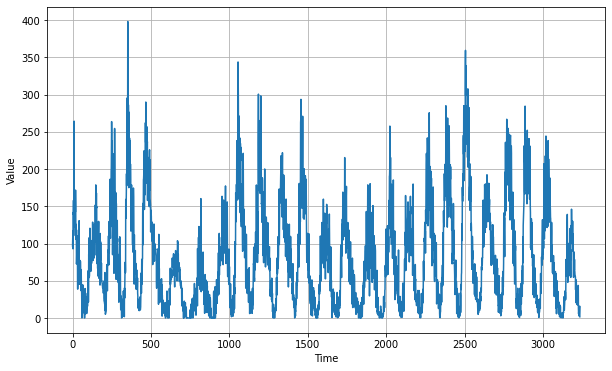

In [7]:
import csv
time_step = []
sunspots = []

with open("/tmp/sunspots.csv") as csv_file:
    reader = csv.reader(csv_file, delimiter=",")
    next(reader)
    for row in reader:
        sunspots.append(float(row[2]))
        time_step.append(int(row[0]))

time = np.array(time_step)
series = np.array(sunspots)

plt.figure(figsize=(10, 6))
plot_series(time, series)

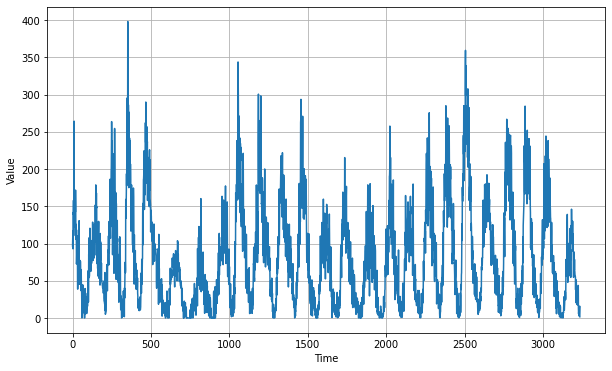

In [8]:
series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [9]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [10]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda x: x.batch(window_size + 1))
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    ds = ds.shuffle(shuffle_buffer_size)
    ds = ds.batch(batch_size).prefetch(1)
    return ds

In [11]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [12]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, 
                           padding="causal", activation="relu",
                           input_shape=[None, 1]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*400)
])

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10 ** (epoch/20)
)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9),
              metrics=["mae"])

history = model.fit(train_set, epochs=100, verbose=1, callbacks=[lr_scheduler])




<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Epoch 1/100
12/12 [==============================] - 0s 23ms/step - loss: 79.8340 - mae: 80.3314
Epoch 2/100
12/12 [==============================] - 0s 20ms/step - loss: 78.0944 - mae: 78.5918
Epoch 3/100
12/12 [==============================] - 0s 21ms/step - loss: 75.4519 - mae: 75.9497
Epoch 4/100
12/12 [==============================] - 0s 22ms/step - loss: 72.2679 - mae: 72.7658
Epoch 5/100
12/12 [==============================] - 0s 22ms/step - loss: 68.7693 - mae: 69.2672
Epoch 6/100
12/12 [==============================] - 0s 22ms/step - loss: 65.1128 - mae: 65.6099
Epoch 7/100
12/12 [==============================] - 0s 20ms/step - loss: 61.5272 - mae: 62.0241
Epoch 8/100
12/12 [==============================] - 0s 21ms/step - loss: 58.1406 - mae: 58.6369
Epoch 9/100
12/12 [==============================] - 0s 21ms/step - loss: 55.0732 - mae: 55.5697
Epoch 10/100
12/12 [=====

(1e-08, 0.0001, 0.0, 60.0)

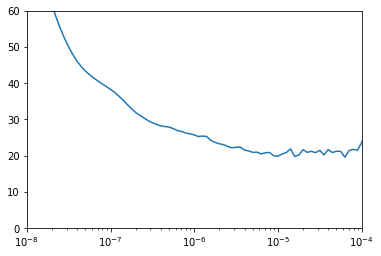

In [13]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [14]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
30/30 [==============================] - 0s 13ms/step - loss: 38.9172 - mae: 39.4135
Epoch 2/500
30/30 [==============================] - 0s 13ms/step - loss: 25.7620 - mae: 26.2565
Epoch 3/500
30/30 [==============================] - 0s 13ms/step - loss: 22.0784 - mae: 22.5721
Epoch 4/500
30/30 [==============================] - 0s 13ms/step - loss: 20.4765 - mae: 20.9695
Epoch 5/500
30/30 [==============================] - 0s 13ms/step - loss: 19.7288 - mae: 20.2213
Epoch 6/500
30/30 [==============================] - 0s 12ms/step - loss: 19.3075 - mae: 19.7996
Epoch 7/500
30/30 [==============================] - 0s 12ms/step - loss: 18.7039 - mae: 19.1959
Epoch 8/500
30/30 [==============================] - 0s 13ms/step - loss: 18.1502 - mae: 18.6419
Epoch 9/500
30/30 [==============================] - 0s 12ms/step - loss: 18.0662 - mae: 18.5577
Epoch 10/500
30/30 [==============================] - 0s 13ms/step - loss: 17.8665 - mae: 18.3577
Epoch 11/500
30/30 [=========

In [15]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

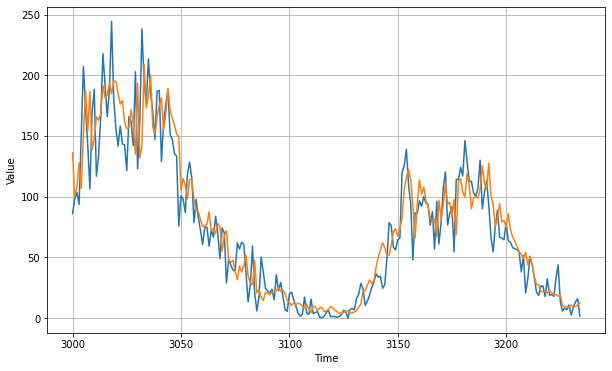

In [16]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [17]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

15.155054

<Figure size 432x288 with 0 Axes>

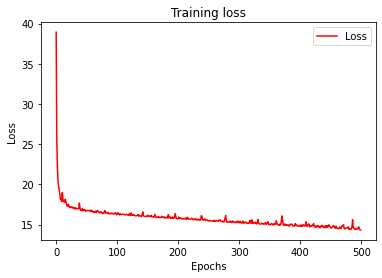

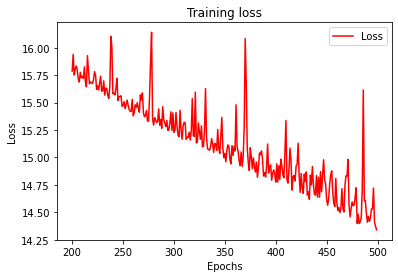

<Figure size 432x288 with 0 Axes>

In [18]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [19]:
print(rnn_forecast)

[136.03291    99.460045  107.17721   127.837204  106.73296   151.08258
 186.9796    154.12106   186.51616   138.57343   148.1033    165.69887
 163.04488   168.25722   191.76627   181.33302   183.79166   193.39783
 184.6686    194.98608   195.15057   185.05878   176.18301   179.1395
 161.53407   155.9043    156.56674   171.66898   160.19969   134.92911
 193.37277   131.72243   141.69565   209.09787   172.95375   183.2038
 200.07787   157.90198   150.96101   165.39047   175.3449    181.29967
 154.74393   167.82698   189.25273   170.93184   164.60002   159.05766
 151.81496   149.03297   104.92258   114.948105  109.452644   98.109955
 114.178444  114.33559    97.8211     88.561264   87.6952     81.04069
  75.52303    75.45862    77.44567    87.42492    71.86652    73.81889
  69.47385    77.90744    74.91843    54.963554   67.33043    72.02325
  47.775967   45.689114   47.583588   38.349472   31.506931   42.824356
  37.756126   43.27535    51.857513   34.51868    28.865055   27.30512
  47.3